In [66]:
from umap import UMAP
import hdbscan
from hdbscan import HDBSCAN
from pymethylprocess.MethylationDataTypes import MethylationArray
from pymethylprocess.general_machine_learning import MachineLearning
import pandas as pd, numpy as np
from sklearn.decomposition import PCA
import matplotlib, matplotlib.pyplot as plt
import seaborn as sns
from seaborn import cubehelix_palette
sns.set()

## Load Data

In [3]:
train_methyl_array=MethylationArray.from_pickle("train_val_test_sets/train_methyl_array.pkl")
val_methyl_array=MethylationArray.from_pickle("train_val_test_sets/val_methyl_array.pkl")
test_methyl_array=MethylationArray.from_pickle("train_val_test_sets/test_methyl_array.pkl")

## UMAP Embed

In [5]:
umap = UMAP(n_components=100)
umap.fit(train_methyl_array.beta)
train_methyl_array.beta = pd.DataFrame(umap.transform(train_methyl_array.beta.values),index=train_methyl_array.return_idx())
val_methyl_array.beta = pd.DataFrame(umap.transform(val_methyl_array.beta),index=val_methyl_array.return_idx())
test_methyl_array.beta = pd.DataFrame(umap.transform(test_methyl_array.beta),index=test_methyl_array.return_idx())

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


## Cluster Training Data

In [47]:
def reduce_plot(data, labels, legend_title):
    np.random.seed(42)
    plt.figure(figsize=(8,8))
    t_data=pd.DataFrame(PCA(n_components=2).fit_transform(data),columns=['z1','z2'])
    t_data[legend_title]=labels
    sns.scatterplot('z1','z2',hue=legend_title, cmap=cubehelix_palette(as_cmap=True),data=t_data)


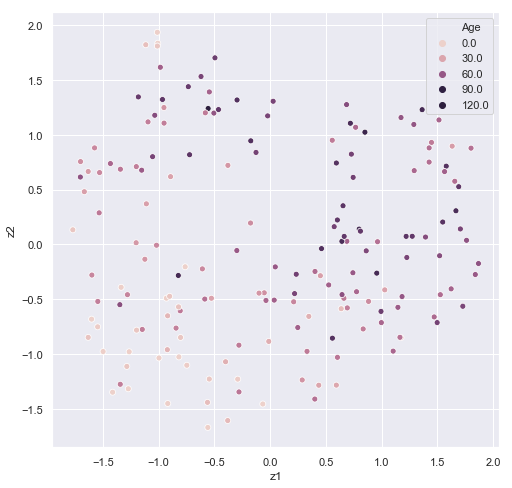

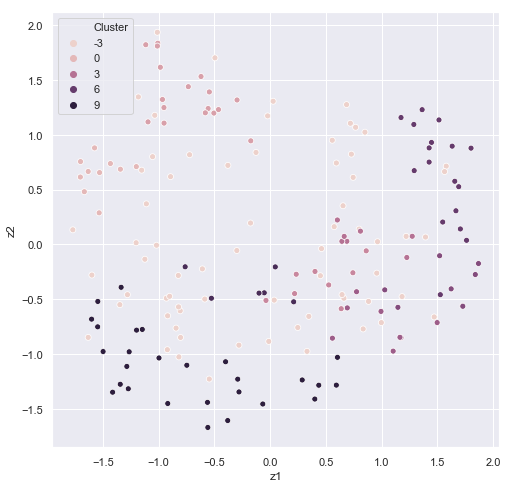

In [48]:
model = HDBSCAN(algorithm='best')
train_predicted_clusters = model.fit_predict(train_methyl_array.beta.astype(np.float64))
reduce_plot(train_methyl_array.beta, train_methyl_array.pheno['Age'].values,'Age')
reduce_plot(train_methyl_array.beta, train_predicted_clusters,'Cluster')

In [65]:
import tabulate
train_methyl_array.pheno['Cluster']=train_predicted_clusters
output_data=train_methyl_array.pheno.groupby('Cluster')['Age'].agg([np.mean,len])
print(tabulate.tabulate(output_data,headers='keys',tablefmt="pipe"))

|   Cluster |    mean |   len |
|----------:|--------:|------:|
|        -1 | 50.8971 |    68 |
|         0 | 43.5    |    10 |
|         1 | 55.3529 |    17 |
|         2 | 56      |     8 |
|         3 | 72.4286 |     7 |
|         4 | 55.375  |     8 |
|         5 | 58.75   |     8 |
|         6 | 59.2353 |    17 |
|         7 | 36.3333 |     6 |
|         8 | 25.4074 |    27 |


## Supervised Model

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

y_pred = {}
scores={}
model=MachineLearning(RandomForestRegressor,options={})
model.fit(train_methyl_array,val_methyl_array,'Age')
y_pred['train']=model.predict(train_methyl_array)
y_pred['val']=model.predict(val_methyl_array)
y_pred['test']=model.predict(test_methyl_array)

scores['train']=r2_score(train_methyl_array.pheno['Age'],y_pred['train'])
scores['val']=r2_score(val_methyl_array.pheno['Age'],y_pred['val'])
scores['test']=r2_score(test_methyl_array.pheno['Age'],y_pred['test'])
scores

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'train': 0.9081939395225365,
 'val': 0.6267152257574171,
 'test': 0.6047109826589596}

(-0.5, 99.5, 0.0, 0.12208564559920049)

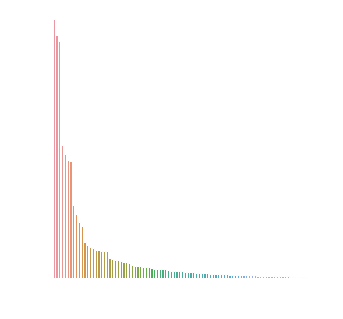

In [132]:
data=pd.DataFrame(model.model.feature_importances_,columns=['Importance'])
data=data.sort_values('Importance').iloc[::-1]
data['sample']=np.arange(len(data.index))

plt.figure(figsize=(5,5))
sns.barplot('sample','Importance',data=data)
plt.axis('off')

A  sample
39  0.116272      39
3   0.109320       3
85  0.106641      85
67  0.060082      67
2   0.055696       2
77  0.053058      77
24  0.052864      24
75  0.032831      75
54  0.028720      54
55  0.025446      55
79  0.023287      79
81  0.016193      81
68  0.015065      68
23  0.014146      23
16  0.013822      16
30  0.012811      30
57  0.012537      57
27  0.012275      27
9   0.012125       9
70  0.012098      70
89  0.008964      89
1   0.008616       1
51  0.008334      51
22  0.008247      22
11  0.007589      11
36  0.007372      36
7   0.007308       7
6   0.007056       6
10  0.005869      10
33  0.005714      33
..       ...     ...
80  0.001300      80
93  0.001291      93
5   0.001284       5
73  0.001209      73
50  0.001159      50
60  0.001109      60
78  0.001028      78
26  0.001012      26
97  0.000998      97
98  0.000951      98
48  0.000935      48
47  0.000882      47
71  0.000864      71
8   0.000848       8
20  0.000832      20
52  0.000781      52
46  0.000617      46
44  0.000607      44
53  0.000595      53
15  0.000539      15
40  0.000404      40
99  0.000329      99
4   0.000226       4
18  0.000212      18
86  0.000184      86
42  0.000159      42
34  0.000138      34
25  0.000137      25
65  0.000096      65
66  0.000031      66

[100 rows x 2 columns]